# Description
Add to the queueing simulator you have already developed (lab 1) some routines to:

a) detect the end of transient in an automated way (write a short report to describe the algorithm you have employed)

b) evaluate the accuracy of results.

Your code should employ a "batch means" technique that adaptively chooses  the number of batches so to achieve outputs with a desired degree of accuracy. 

Define properly the accuracy metric, which should be related to the width of confidence intervals.

Plot of the average delay in function of the utilisation, where the utilisation is: 0.1, 0.2, 0.4, 0.7, 0.8, 0.9, 0.95, 0.99. Show also the 95%-level confidence intervals.

Consider three scenarios for the service time:

EXP: exponentially distributed with mean=1

DET: deterministic =1

HYP:  distributed according to a hyper-exponential distribution with mean=1 standard deviation=10

In [84]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import random
import numpy as np

# Defining functions and classes

In [85]:
def arrival(time, FES, queue, average_arrival_time, average_service_time):
    
    global users
    global customer
    
    # introducing random client arrival
    # inter_arrival = np.random.exponential(1.0/average_arrival_time)
    inter_arrival = random.expovariate(1.0/average_arrival_time)
    #FES.put((time + inter_arrival, 'arrival'))
    FES.append((time + inter_arrival, 'arrival'))
    
    # managing the event 
    users += 1
    x = 'client' + str(customer)
    customer += 1
    
    # recording client id and put it in the list
    client = Client(x, time)
    queue.append(client)

    print(f'{client.name} arrived at {client.arrival_time}')
    
    # start the service in case the server is idle
    if users == 1:
        # scheduling random departure time to the clients
        # service_time = np.random.exponential(1.0/average_service_time)
        # service_time = random.expovariate(1.0/average_service_time)
        service_time = average_service_time
        FES.append((time + service_time, 'departure'))


def departure(time, FES, queue, average_arrival_time, average_service_time):
    
    global users
    
    # manipulating the list of clients to get FIFO orientation
    queue.reverse()
    client = queue.pop()
    queue.reverse()
    users -= 1
    delay = time - client.arrival_time
    
    print(f'{client.name} departured at {time}')
    
    # checking the number of clients in line
    if users > 0:
        # scheduling random departure time to the clients
        # service_time = np.random.exponential(1.0/average_service_time)
        # service_time = random.expovariate(1.0/average_service_time)
        service_time = average_service_time
        FES.append((time + service_time, 'departure'))
    
    return delay

class Client:
    def __init__(self, name, arrival_time):
        self.name = name
        self.arrival_time = arrival_time
        

# Finding transient knee (k)
In order to find the transient knee (k), we should implement the simulation for a long time and compute the average. Afterwards, we should calculate the average depending on k to plot. Fianlly, k is determined by this plot.

In [86]:
# def transient_point(variance_list):
    
#     var_ave = np.mean(variance_list)
#     var_std = np.std(variance_list)
#     print(var_ave, var_std)
#     var_max = max(variance_list)
#     j = variance_list.index(var_max)
    
#     for i in range(j, len(variance_list)):
#         if (variance_list[i] > var_ave - var_std/2) and (variance_list[i] < var_ave + var_std/2):
#             return i


def transient_point(cumulative_delay, u):
    
    ave = np.mean(cumulative_delay)
    std = np.std(cumulative_delay)
    
    if u <= 0.7:
        j = int(len(cumulative_delay) * u)
    else:
        j = int(len(cumulative_delay) * 0.7)
    
    for i in range(j, len(cumulative_delay)):
        if (cumulative_delay[i] > ave - std) and (cumulative_delay[i] < ave + std):
            return i



def confidence_interval_margin(batch_mean_list, confidence_interval):
    
    mu = np.mean(batch_mean_list)
    std = np.std(batch_mean_list)
    n = len(batch_mean_list)
    t = np.abs(ss.t.ppf((1-confidence_interval)/2, n - 1))
    
    margin = t * std / np.sqrt(n)
    
    expanding_condition = 2 * margin / mu
    
    return mu, margin, expanding_condition


import math
def hyper_expo() -> float:
    # """
    # This function generate an hyperexponential time according the definition of the hyperexponential itself.
    # Distribution's parameters found by solving the corresponding linear system for target mean and std.
    # More on that in the report.
    # """
    # p = .5
    # l1 = 1/1.5
    # l2 = 1/1.1
    # u = random.random()
    # v = random.random()
    # if u <= p:
    #     service = -1.5 * math.log(1 - v)
    # else:
    #     service = -1.1 * math.log(1 - v)
    
    
    # return service
    
    """
    This function generate an hyperexponential time according the definition of the hyperexponential itself.
    Distribution's parameters found by solving the corresponding linear system for target mean and std.
    More on that in the report.
    """
    p = .5
    l1 = 1/6
    l2 = 1/8
    u = random.random()
    if u <= p:
        expec = l1
    else:
        expec = l2
    service = random.expovariate(1/expec)
    return service


In [87]:
np.random.seed(32)
random.seed(42)

simulation_time = 50000
simulation_time_warm_up = 10000
utilization = [0.1, 0.2, 0.4, 0.7, 0.8, 0.9, 0.95, 0.99]
distributions = ['deterministic', 'exponential', 'hyperexponential']

dict_simulation = {}

accuracy = 0.1

for u in [0.9]:
    
    for distribution in ['hyperexponential']:
        
        time = 0
        users = 0
        customer = 1
        queue = []
        FES = []
        delay = []
        
        average_arrival_time = 1/u #***************************************************
        confidence_interval = 0.95
        
        cumulative_delay = []
        variance_delay = []
        
        
        batch_mean_list = []
        expanding_number = 0
        batche_initial_size = 10
        batch_count = 10
        flag =1
        
        FES.append((0,'arrival'))
        target = 0
        
        
        while time < simulation_time and flag:
            # average_service_time = random.expovariate(1)
            average_service_time = hyper_expo()
            
            # Lambda = u/average_service_time
            # average_arrival_time = 1/Lambda
            
            if distribution == 'deterministic':
                average_service_time = 1
            elif distribution == 'exponential':
                average_service_time = random.expovariate(1)
            else:
                average_service_time = hyper_expo()
            
            # average_arrival_time = average_service_time/u #***************************************************
            
            FES = sorted(FES)
            (time, event_type) = FES[target]
            
            if event_type == 'arrival':
                arrival(time, FES, queue, average_arrival_time, average_service_time)
            elif event_type == 'departure':
                delay.append(departure(time, FES, queue, average_arrival_time, average_service_time))
                cumulative_delay.append(sum(delay)/len(delay))
                # variance_delay.append(np.var(delay))
            
            if time > int((simulation_time_warm_up * (1 + u) + expanding_number)):
                
                if expanding_number == 0:
                    k = transient_point(cumulative_delay, u)
                    # batch_size = int(((len(cumulative_delay) - k)/batche_initial_size))
                    batch_size = int(((simulation_time_warm_up * (1 + u) - k)/batche_initial_size))
                    batch_start_index = k
                else:
                    batch_start_index = len(cumulative_delay) - batch_size
                
                
                while(batch_start_index < len(cumulative_delay)):
                    batch_mean_list.append(np.mean(cumulative_delay[batch_start_index:(batch_start_index + batch_size)]))
                    batch_start_index += batch_size
                
            
                mu, margin, expanding_condition  = confidence_interval_margin(batch_mean_list, confidence_interval)
                print(f'margin is:*******************************{margin}**********************')
                
                if expanding_condition > accuracy:
                    expanding_number += batch_size
                    batch_count += 1
                else:
                    flag = 0
                    
            target += 1
        # 'k': k, 'last_mu': last_mu, 'ci': ci, 'batch_count': batch_count, 'batch_size': batch_size, 'cumulative_delay': cumulative_delay
        # dict_simulation[(u, distribution)] =  [k, last_mu, ci, batch_count, batch_size, cumulative_delay]
        dict_simulation[(u, distribution)] = {'k': k, 'last_mu': mu, 'ci': (mu - 2 * margin, mu + 2 * margin), 'batch_count': batch_count, 'batch_size': batch_size, 'cumulative_delay': cumulative_delay}
          
        

client1 arrived at 0
client1 departured at 0.04209769761168559
client2 arrived at 1.4817696364534256
client2 departured at 1.485131436913464
client3 arrived at 1.7280937133019596
client3 departured at 1.8778174559236454
client4 arrived at 2.1901993649670497
client4 departured at 2.395915607392707
client5 arrived at 3.643910954351791
client5 departured at 3.7515629470203966
client6 arrived at 4.998721590182715
client6 departured at 5.167010736105128
client7 arrived at 5.5030171789828435
client8 arrived at 5.701252957658337
client7 departured at 5.720701255101574
client8 departured at 5.726139047571597
client9 arrived at 6.98342939025321
client9 departured at 7.046375869171659
client10 arrived at 9.71653568264669
client10 departured at 9.780264053208297
client11 arrived at 9.991636701147153
client11 departured at 10.06019397712011
client12 arrived at 10.064564859282143
client12 departured at 10.207664049468915
client13 arrived at 10.920080576791596
client13 departured at 10.9582925031044

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


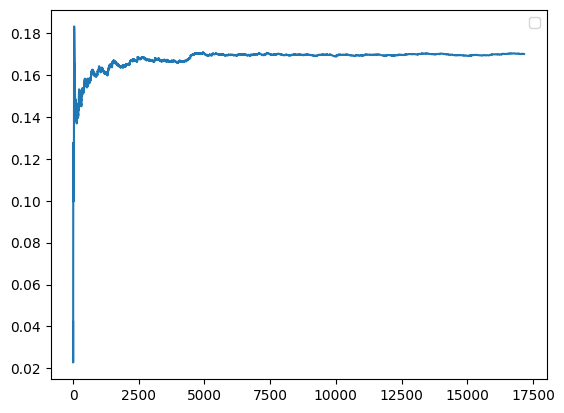

In [88]:
plt.plot(cumulative_delay)
# plt.yscale('log')
# plt.plot(variance_delay, label='kir')
# plt.yscale('log')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


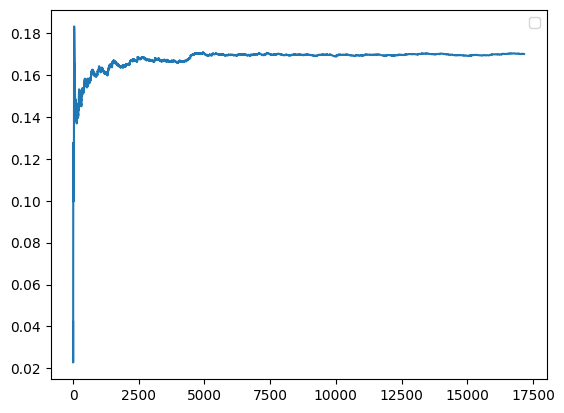

In [89]:
# plt.plot(cumulative_delay)
plt.plot(dict_simulation[(0.9, 'hyperexponential')]['cumulative_delay'])
# plt.plot(variance_delay, label='kir')
# plt.yscale('log')
plt.legend()

In [90]:
for key in dict_simulation.keys():
    print(dict_simulation[key]['k'])

12015


In [91]:
import pandas as pd

df = pd.DataFrame.from_dict(dict_simulation)
df

,0.9
,hyperexponential
batch_count,10
batch_size,698
ci,"(0.1695173406057838, 0.17044092251949808)"
cumulative_delay,"[0.04209769761168559, 0.022729749035862005, 0...."
k,12015
last_mu,0.169979


In [92]:
cumulative_delay

[0.04209769761168559,
 0.022729749035862005,
 0.06506108023113659,
 0.10022487077976672,
 0.10171029515753452,
 0.11280677028501433,
 0.12778924254697374,
 0.11492634846775956,
 0.10915080740672506,
 0.1046085637222133,
 0.10133117392682633,
 0.10481184194848851,
 0.09968877151497614,
 0.10968282510369273,
 0.11721898994784234,
 0.12123441906647595,
 0.11744742850608741,
 0.11474311747200155,
 0.10918751260261805,
 0.11402590903097762,
 0.10921279513694375,
 0.10642603199629064,
 0.11597632274322016,
 0.11274898162663162,
 0.11058557477858637,
 0.10715584965152666,
 0.10449567262237007,
 0.101981136676046,
 0.1223691506440829,
 0.14364608593881786,
 0.15028546460229172,
 0.15269998741615448,
 0.1555199576739467,
 0.1595585740582732,
 0.16203955742057055,
 0.15812141067830365,
 0.16587931854233787,
 0.16234166011957,
 0.166716228357973,
 0.17721499581780703,
 0.18335392700285763,
 0.1830199115266955,
 0.17980181891301225,
 0.182337691278641,
 0.18002314941140768,
 0.17883305998931262,
 